# Negative L1 norm prior experiment

This code attempts to learn the 16D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 16

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 30000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 7113.849609375
iteration 0 loss 2306.50439453125


iteration 5000 loss 1.117537021636963


iteration 10000 loss 0.3057955205440521


iteration 15000 loss 0.11637753993272781


iteration 20000 loss 0.08480604737997055


iteration 25000 loss 1.4329971075057983


iteration 30000 loss 0.056199777871370316


iteration 35000 loss 0.7414724230766296


iteration 40000 loss 0.044265229254961014


iteration 45000 loss 0.04039537161588669


iteration 50000 loss 0.03764227777719498


iteration 55000 loss 0.036230698227882385


iteration 60000 loss 0.03920120745897293


iteration 65000 loss 0.03213844448328018


iteration 70000 loss 0.03132480010390282


iteration 75000 loss 0.029910186305642128


iteration 80000 loss 0.027762560173869133


iteration 85000 loss 0.027482839301228523


iteration 90000 loss 0.02557421661913395


iteration 95000 loss 0.024601755663752556


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.023799845948815346


iteration 105000 loss 0.022169165313243866


iteration 110000 loss 0.020825691521167755


iteration 115000 loss 0.019739139825105667


iteration 120000 loss 0.018831705674529076


iteration 125000 loss 0.018036484718322754


iteration 130000 loss 0.01732533611357212


iteration 135000 loss 0.01668521761894226


iteration 140000 loss 0.016088644042611122


iteration 145000 loss 0.015541670843958855


iteration 150000 loss 0.015052886679768562


iteration 155000 loss 0.014986542984843254


iteration 160000 loss 0.014178138226270676


iteration 165000 loss 0.013775463216006756


iteration 170000 loss 0.013389422558248043


iteration 175000 loss 0.013099635019898415


iteration 180000 loss 0.012692148797214031


iteration 185000 loss 0.012366906739771366


iteration 190000 loss 0.012060040608048439


iteration 195000 loss 0.011774679645895958


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.011498598381876945


iteration 205000 loss 0.011355177499353886


iteration 210000 loss 0.011119069531559944


iteration 215000 loss 0.0108938654884696


iteration 220000 loss 0.010666292160749435


iteration 225000 loss 0.010452354326844215


iteration 230000 loss 0.01024574227631092


iteration 235000 loss 0.01004787441343069


iteration 240000 loss 0.009862215258181095


iteration 245000 loss 0.009676236659288406


iteration 250000 loss 0.009499032981693745


iteration 255000 loss 0.009336470626294613


iteration 260000 loss 0.009176885709166527


iteration 265000 loss 0.00901887658983469


iteration 270000 loss 0.008877458982169628


iteration 275000 loss 0.008735994808375835


iteration 280000 loss 0.008592363446950912


iteration 285000 loss 0.008463975973427296


iteration 290000 loss 0.008343382738530636


iteration 295000 loss 0.008223463781177998


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.008108056150376797


iteration 305000 loss 0.008058496750891209


iteration 310000 loss 0.007924205623567104


iteration 315000 loss 0.007799346931278706


iteration 320000 loss 0.0076764789409935474


iteration 325000 loss 0.007558443583548069


iteration 330000 loss 0.0074470192193984985


iteration 335000 loss 0.007339088711887598


iteration 340000 loss 0.007233970332890749


iteration 345000 loss 0.007133843842893839


iteration 350000 loss 0.007035542279481888


iteration 355000 loss 0.0069432039745152


iteration 360000 loss 0.006848467979580164


iteration 365000 loss 0.006761637050658464


iteration 370000 loss 0.006675083655864


iteration 375000 loss 0.006591496989130974


iteration 380000 loss 0.006512673106044531


iteration 385000 loss 0.0064355856738984585


iteration 390000 loss 0.006359789054840803


iteration 395000 loss 0.006286668125540018


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.006213111337274313


iteration 405000 loss 0.006188521161675453


iteration 410000 loss 0.006145155522972345


iteration 415000 loss 0.0061029428616166115


iteration 420000 loss 0.0060616424307227135


iteration 425000 loss 0.006021172273904085


iteration 430000 loss 0.005981395952403545


iteration 435000 loss 0.005942336283624172


iteration 440000 loss 0.005903908051550388


iteration 445000 loss 0.005866116378456354


iteration 450000 loss 0.00582896638661623


iteration 455000 loss 0.0057923817075788975


iteration 460000 loss 0.005756475031375885


iteration 465000 loss 0.005721127614378929


iteration 470000 loss 0.005686226300895214


iteration 475000 loss 0.0056518311612308025


iteration 480000 loss 0.0056179119274020195


iteration 485000 loss 0.005584447178989649


iteration 490000 loss 0.005551393609493971


iteration 495000 loss 0.0055187479592859745


L2 loss -- Plot

loss 959.427001953125


loss 888.5828247070312


loss 864.56689453125


loss 853.0350341796875


loss 847.474365234375


loss 844.9619750976562


loss 843.943603515625


loss 843.5906982421875


loss 843.4925537109375


loss 843.4722900390625


loss 843.469482421875


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


loss 843.46923828125


final mse:  1.128570392694428e-08
max, min: 2.1937792 -2.2320566
loss 959.427001953125


loss 889.8997192382812


loss 867.5096435546875


loss 857.1715087890625


loss 852.3527221679688


loss 850.23974609375


loss 849.4061889648438


loss 849.1248168945312


loss 849.0484619140625


loss 849.0331420898438


loss 849.0311279296875


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


loss 849.0309448242188


final mse:  1.023605822325635e-08
max, min: 2.1895976 -2.0889115


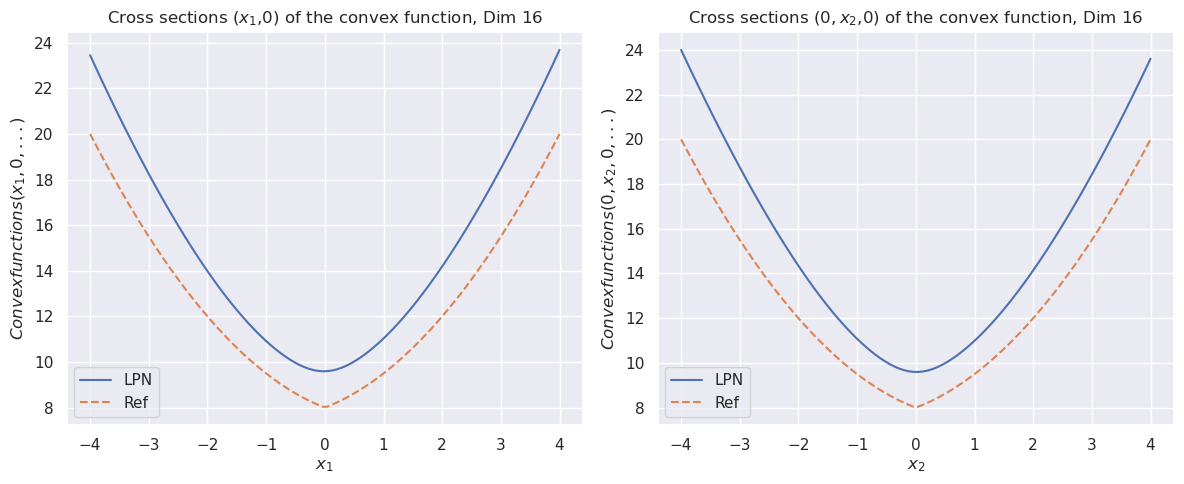

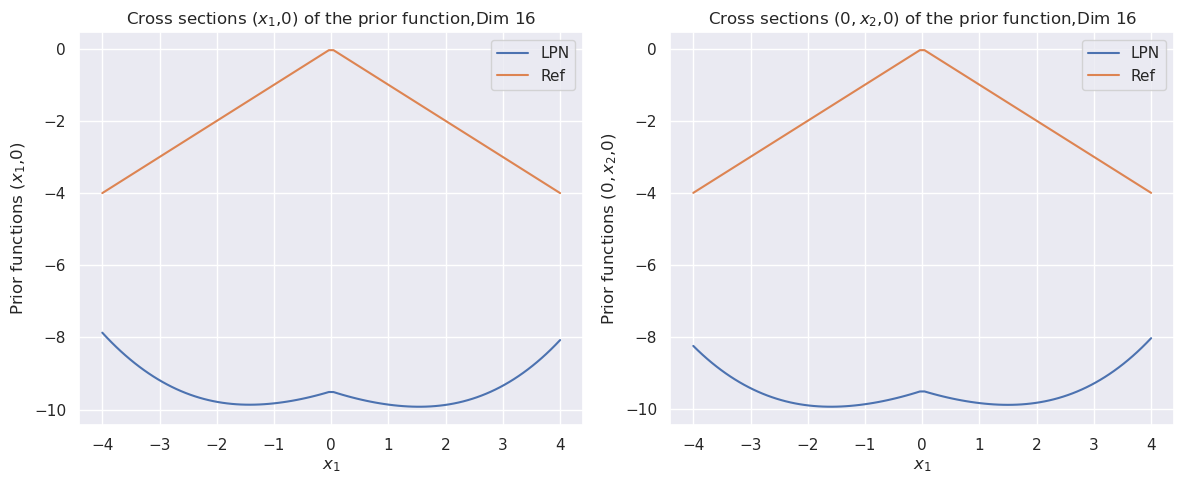

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1206.2415771484375
iteration 0 loss 463.899169921875


iteration 5000 loss 0.7606164216995239


iteration 10000 loss 0.5604814887046814


iteration 15000 loss 0.4850112795829773


iteration 20000 loss 0.4226521849632263


iteration 25000 loss 0.38227277994155884


iteration 30000 loss 0.35477524995803833


iteration 35000 loss 0.34268301725387573


iteration 40000 loss 0.3160259425640106


iteration 45000 loss 0.300076961517334


iteration 50000 loss 0.30121082067489624


iteration 55000 loss 0.27745065093040466


iteration 60000 loss 0.2586294412612915


iteration 65000 loss 0.2458866536617279


iteration 70000 loss 0.2459987998008728


iteration 75000 loss 0.22921623289585114


iteration 80000 loss 0.21998067200183868


iteration 85000 loss 0.21442480385303497


iteration 90000 loss 0.21827031672000885


iteration 95000 loss 0.20864976942539215


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.1916166990995407


iteration 105000 loss 0.18515512347221375


iteration 110000 loss 0.1747707724571228


iteration 115000 loss 0.16718702018260956


iteration 120000 loss 0.1609100103378296


iteration 125000 loss 0.15473926067352295


iteration 130000 loss 0.14852066338062286


iteration 135000 loss 0.1432771533727646


iteration 140000 loss 0.13892310857772827


iteration 145000 loss 0.13460178673267365


iteration 150000 loss 0.13058710098266602


iteration 155000 loss 0.12658552825450897


iteration 160000 loss 0.12299849092960358


iteration 165000 loss 0.11944489181041718


iteration 170000 loss 0.11599993705749512


iteration 175000 loss 0.11292517930269241


iteration 180000 loss 0.10998794436454773


iteration 185000 loss 0.1072385162115097


iteration 190000 loss 0.10448906570672989


iteration 195000 loss 0.10162319242954254


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.09907735139131546


iteration 205000 loss 0.09705545008182526


iteration 210000 loss 0.09447192400693893


iteration 215000 loss 0.09192734211683273


iteration 220000 loss 0.0894034206867218


iteration 225000 loss 0.08744712918996811


iteration 230000 loss 0.08547210693359375


iteration 235000 loss 0.08318386971950531


iteration 240000 loss 0.08095742017030716


iteration 245000 loss 0.07853613048791885


iteration 250000 loss 0.07595527917146683


iteration 255000 loss 0.07194012403488159


iteration 260000 loss 0.068452388048172


iteration 265000 loss 0.0645824447274208


iteration 270000 loss 0.05997749790549278


iteration 275000 loss 0.05616343766450882


iteration 280000 loss 0.052009087055921555


iteration 285000 loss 0.04912151023745537


iteration 290000 loss 0.046244923025369644


iteration 295000 loss 0.043690331280231476


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.040887437760829926


iteration 305000 loss 0.04059058427810669


iteration 310000 loss 0.039327897131443024


iteration 315000 loss 0.037860892713069916


iteration 320000 loss 0.03652250021696091


iteration 325000 loss 0.03526151552796364


iteration 330000 loss 0.03403604030609131


iteration 335000 loss 0.03281708434224129


iteration 340000 loss 0.03163282573223114


iteration 345000 loss 0.03051026724278927


iteration 350000 loss 0.029453834518790245


iteration 355000 loss 0.028455883264541626


iteration 360000 loss 0.02750924602150917


iteration 365000 loss 0.02660701982676983


iteration 370000 loss 0.02574285864830017


iteration 375000 loss 0.02490258775651455


iteration 380000 loss 0.02407105825841427


iteration 385000 loss 0.023255981504917145


iteration 390000 loss 0.022464483976364136


iteration 395000 loss 0.021709946915507317


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.020990297198295593


iteration 405000 loss 0.020903894677758217


iteration 410000 loss 0.020811868831515312


iteration 415000 loss 0.020722342655062675


iteration 420000 loss 0.020634351298213005


iteration 425000 loss 0.020547494292259216


iteration 430000 loss 0.020461631938815117


iteration 435000 loss 0.020376648753881454


iteration 440000 loss 0.02029251679778099


iteration 445000 loss 0.02020910754799843


iteration 450000 loss 0.020126406103372574


iteration 455000 loss 0.02004428394138813


iteration 460000 loss 0.019962679594755173


iteration 465000 loss 0.01988161727786064


iteration 470000 loss 0.019800996407866478


iteration 475000 loss 0.019720856100320816


iteration 480000 loss 0.01964123547077179


iteration 485000 loss 0.01956203207373619


iteration 490000 loss 0.019483206793665886


iteration 495000 loss 0.019404808059334755


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


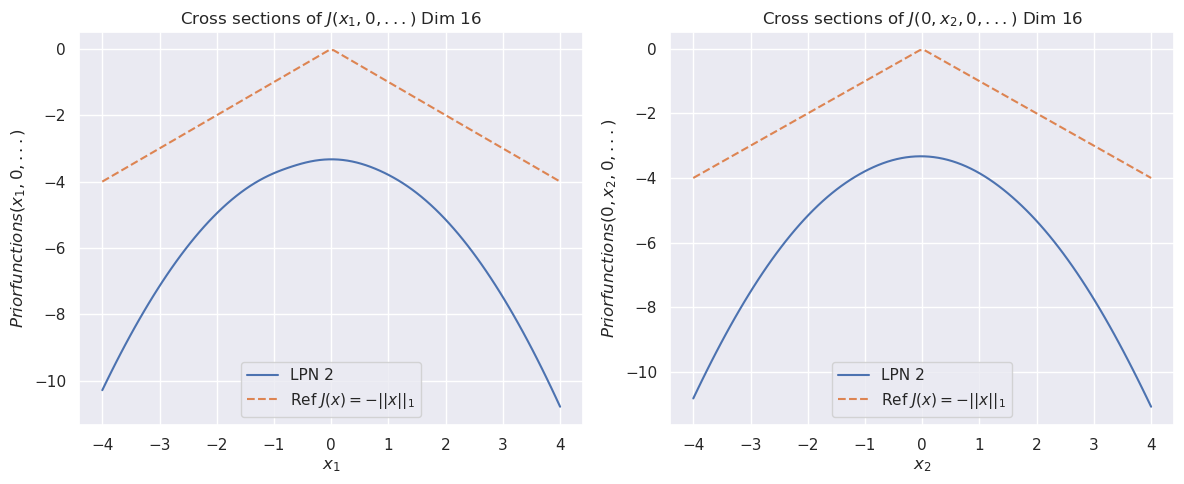

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)